# Introduction
## Problem Statement
You are a performing arts organizing agency whose mainstream source of revenue is organizing sensational events/gigs for public entertainment from conception to execution. You aim to organize hundreds of events both highly frequent small scale ones and occasional large scale ones. You work with all kinds of performance artists like actors, comedians, dancers, magicians, circus artists, musicians, and singers, songwriters, choreographers, and so on.
<br>
One of the major decisions that have to be made is the selection of an appropriate venue for a performance. For this, the agency needs not only a holistic list of venues in an area but also to group it with tags like nightlife, small scale, relevant performance art that can be performed here, etc. So that an optimal decision can be arrived at.
<br>
Once the database for the area of interest is built, a simple K-means clustering would reveal the best zones for further classification and analysis.

<h2>Target audience and Utility</h2>
    
The database once built and analyzed would be of tremendous utility to all companies/agencies involved in any subdomain of the performing arts ecosystem. A few scenarios would help in grasping of the underlying value of this project:
<ol>
<li>An individual comic/ group of comics scouting for popular locations to perform and showcase their gigs throughout a particular city/area.</li>
<li>Musical Bands/ individual performers looking for crowded venues and popular locations to perform frequently to increase ticket sales.</li>
<li>Play actors/ dance performers and a host of other performing artists aiming to maximize the reach, popularity, and ticket sales for their art.</li>
<li>Supporting staff like choreographers, songwriters, scriptwriters, cameramen, etc looking for employment opportunities.</li>
<li>Not only the supply side but the demand side too, for instance, art enthusiasts and staple audiences of each of the above-mentioned arts can benefit too. </li></ol>






# Data section :
## Dataset fabrication:
The aim is to construct a comprehensive, all-encompassing database of venues, complete with useful labels like enabled night shows, the scale of the event that can be hosted, etc.

To construct such a dataset, one would have to partition the geographical area of interest into non-overlapping subsets of the critical size (see next para). The query will be run on the center of the geographical confine and relevant properties of the results will be used to populate a conspicuous, intuitive dataset for further use.

The foursquare API for venue search has a cap of 30 results for a given query, implying that all the popular performing arts venues might not be revealed if the area size exceeds a critical size (at which any further decrement in size would decrease the query results to below 30).
2.2. Area of Interest and Description:
For this project, we would be looking at the very heart of the culture-rich city of Milan. 
Milan is the capital of Lombardia, along with being the richest and most populous region of Italy, it is the second-largest in the country, and is best known as an economic and financial center but it also has its fair share of cultural and architectural attractions.

Zone 1 of Milan city comprises within it, districts of Brera and Porta Sempione, which bubble with its richness of Art and Nightlife.

Brera houses the Brera Academy of Fine Arts and the Brera Art Gallery, which prominently contributed to the development of Brera as an artists' neighborhood and a place of bohemian atmosphere, sometimes referred to as "the Milanese Montmartre".
Other features that contribute to the character of Brera include restaurants, bars, night clubs, antique and art shops, colorful street markets, as well as fortune tellers' booths.

The whole area is one of the centers of the so-called Milanese Movida (nightlife), with a number of bars, pubs, restaurants, and discos; since the RAI public television company, as well as some major radio stations, have their headquarters in the area, frequent appearances of celebrities contribute to the popularity of the Sempione's nightlife venues.


## Import relevant packages

In [79]:
#--- general data processing and visualzation ---
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

#--- to handle url requests for making API calls ---
import requests

#-- to transform spherical coordinates to cartesian and vice versa ---
import pyproj

#--- to normalize json type string to dataframe ---
from pandas.io.json import json_normalize

## The make grid function
Given a radius of a circle and a side length value, the function generates a grid of sqaure cells of that side. The function plots it using Matplotlib to make it visually tangible. 

In [2]:
def make_grid(R,s):
    #--- parameters ---
    center_x = R
    center_y = R
    side  = 2*R
    r = s/2
    
    diag_x = center_x - R
    diag_y = center_y - R
    root_3 = math.sqrt(3)
    
    def check_circle(x,y):
        val = math.sqrt(pow((center_x-x),2)+pow((center_y-y),2)) - R
        if(val>0):
            return False
        else:
            return True
    

    #--- Figure properties ---
    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlim(diag_x-5,diag_x+side+5)
    plt.ylim(diag_y-5,diag_y+side+5)
    plt.grid(linestyle='--')
    ax.set_aspect(1)

    #--- main outer square ---
    x1, y1 = [diag_x,diag_x+side], [diag_y,diag_y]
    x2, y2 = [diag_x+side,diag_x+side], [diag_y,diag_y+side]
    x3, y3 = [diag_x+side,diag_x], [diag_y+side,diag_y+side]
    x4, y4 = [diag_x,diag_x], [diag_y+side,diag_y]
    square = plt.plot(x1, y1, x2, y2, x3, y3, x4, y4, marker = 'o')
    map(ax.add_artist,square)

    #--- main circle ---
    main_circle = plt.Circle((center_x,center_y),R, color = 'gold', alpha = 0.6)
    ax.add_artist(main_circle)

    #--- intermediate circle centers of readius r---
    x_coords = np.arange(diag_x+r,diag_x+side+r,2*r)
    y_coords = np.arange(diag_y+r,diag_y+side+r,2*r)

    for X in x_coords:
        for Y in y_coords:
            if (check_circle(X,Y)):
                x = X - r
                y = Y - r
                x1, y1 = [x,x+s], [y,y]
                x2, y2 = [x+s,x+s], [y,y+s]
                x3, y3 = [x+s,x], [y+s,y+s]
                x4, y4 = [x,x], [y+s,y]
                square = plt.plot(x1, y1, x2, y2, x3, y3, x4, y4)
                map(ax.add_artist,square)
            else:
                pass

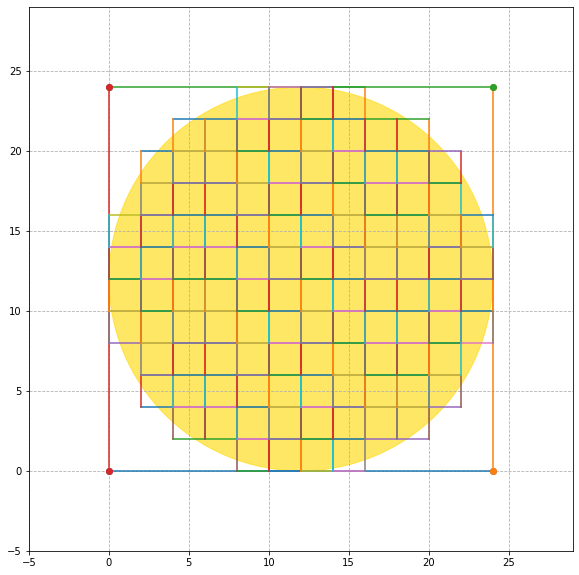

In [3]:
make_grid(12,2)

## Transformation Functions
These functions will be used to convert coordinates of a point in one coordinate system to other and vice versa. Here, the 2 coordinate systems are Spherical system [lat,lng] and the Cartesian Coordinate system, [x,y]

In [67]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=32, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=32, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

#--- this funciton is a part of 'venues_to_df()' function defined here just for the sake of defining. To be used later ----
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Testing the transformations
To test whether the transformation functions are working as intended, a set of boundary points on the boundary of zone 1 of Milan are selected and plotted in the Cartesian Coordinates and then compared. (see report)

C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the

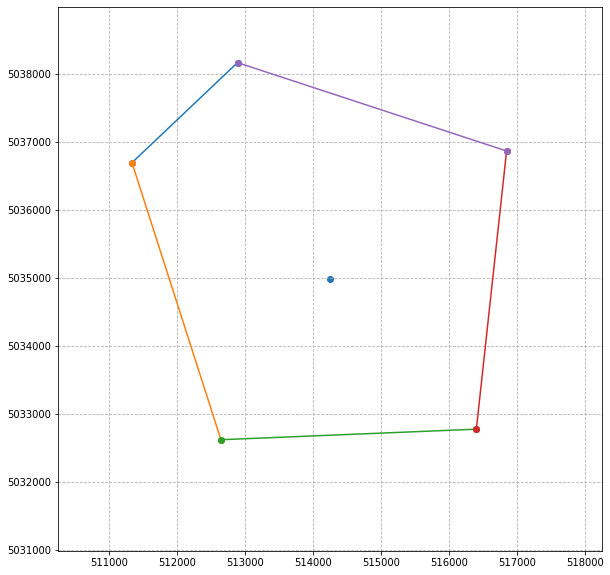

In [6]:
bound = [[45.49691, 9.16495],[45.48368, 9.14504],[45.44696, 9.16169],[45.44828, 9.20976],[45.48512, 9.21559]]
center = [45.46822, 9.18228]

X = []
Y = []

for p in bound:
    x,y = lonlat_to_xy(p[1],p[0])
    X.append(x)
    Y.append(y)
    
x_1= 514248.9621533059 
y_1 = 5034982.006261798

fig, ax = plt.subplots(figsize = (10,10))
plt.xlim(x_1-4000,x_1+4000)
plt.ylim(y_1-4000,y_1+4000)
plt.grid(linestyle='--')
ax.set_aspect(1)

x1, y1 = [X[0],X[1]],[Y[0],Y[1]]
x2, y2 = [X[1],X[2]],[Y[1],Y[2]]
x3, y3 = [X[2],X[3]],[Y[2],Y[3]]
x4, y4 = [X[3],X[4]],[Y[3],Y[4]]
x5, y5 = [X[4],X[0]],[Y[4],Y[0]]

square = plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,x5,y5, marker = 'o')
map(ax.add_artist,square)

plt.scatter([x_1],[y_1])

## Constructing the required URL for API calls
The category of venues to be included in the API call, were decided on the basis of the list of categories available with the documentation of the venues search API. The categories are provided as a list of comma separated category IDs.

### Relevant Location types:
1. Amphitheater
56aa371be4b08b9a8d5734db

2. Comedy Club
4bf58dd8d48988d18e941735

3. Concert Hall
5032792091d4c4b30a586d5c

4. General Entertainment
4bf58dd8d48988d1f1931735

5. Opera House
4bf58dd8d48988d136941735

6. Theater
4bf58dd8d48988d137941735

7. Lounge
4bf58dd8d48988d121941735

8. Nightclub
4bf58dd8d48988d11f941735

9. Music Venue
4bf58dd8d48988d1e5931735


In [148]:
CLIENT_ID = 'CQTF5U0CCI2SPBLT5N3TO2HYTFJFA0UOL2SNNXW2SVCDZXMK' # your Foursquare ID
CLIENT_SECRET = 'FPQAH1O2DPPX0LA4A01GS5DGWHZAL1L4KHVKAZ3M3XJQBEGM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
categ_list = ['4bf58dd8d48988d1f1931735','5032792091d4c4b30a586d5c','4bf58dd8d48988d18e941735','56aa371be4b08b9a8d5734db',
         '4bf58dd8d48988d1e5931735','4bf58dd8d48988d11f941735','4bf58dd8d48988d121941735','4bf58dd8d48988d137941735']

CATEGS = '4bf58dd8d48988d136941735'
for c in categ_list:
    CATEGS = CATEGS + ',' + c
print('CSV_CATEGS :' + CATEGS)

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&sw={}&ne={}&intent=browse&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION,SW,NE,CATEGS)
url

Your credentails:
CLIENT_ID: CQTF5U0CCI2SPBLT5N3TO2HYTFJFA0UOL2SNNXW2SVCDZXMK
CLIENT_SECRET:FPQAH1O2DPPX0LA4A01GS5DGWHZAL1L4KHVKAZ3M3XJQBEGM
CSV_CATEGS :4bf58dd8d48988d136941735,4bf58dd8d48988d1f1931735,5032792091d4c4b30a586d5c,4bf58dd8d48988d18e941735,56aa371be4b08b9a8d5734db,4bf58dd8d48988d1e5931735,4bf58dd8d48988d11f941735,4bf58dd8d48988d121941735,4bf58dd8d48988d137941735


'https://api.foursquare.com/v2/venues/search?client_id=CQTF5U0CCI2SPBLT5N3TO2HYTFJFA0UOL2SNNXW2SVCDZXMK&client_secret=FPQAH1O2DPPX0LA4A01GS5DGWHZAL1L4KHVKAZ3M3XJQBEGM&v=20180604&sw=45.4749123159139,9.215885891163369&ne=45.478278562382776,9.220696790889232&intent=browse&categoryId=4bf58dd8d48988d136941735,4bf58dd8d48988d1f1931735,5032792091d4c4b30a586d5c,4bf58dd8d48988d18e941735,56aa371be4b08b9a8d5734db,4bf58dd8d48988d1e5931735,4bf58dd8d48988d11f941735,4bf58dd8d48988d121941735,4bf58dd8d48988d137941735'

##  Finding the critical size

The next step in our problem is figuring out the side length of the square cell to be used for grid generation. 

The side should be such that when the API is called, it returns just short of 30 entries. 

Any decrease in side length would cause lesser than 30 results, and the result bandwidth of the API query will be wasted. 

Any more than the critical size, and we would miss out on some venues. (eg: 65 venues exist in reality but the API returns only 30 as that is the cap limit]

The distribution density of each kind of location mentioned in the ‘Relevant Location types’ section would vary among different regions of our AOI. 

As a solution, we appeal to common sense and select a point where there is a high density of such venues known beforehand. 

We iteratively find out the critical size and use that as the length of our square as cell length for the grid.


In [27]:
sw_lon = 9.18819
sw_lat = 45.46058
critic_side = 700
calls = 0

for side in np.arange(650,99,-25):
    
    print('Loop running for side : '+str(side))
    sw_x, sw_y = lonlat_to_xy(sw_lon,sw_lat)
    ne_x = sw_x + side
    ne_y = sw_y + side
    ne_lon, ne_lat = xy_to_lonlat(ne_x, ne_y)
    
    SW = str(sw_lat) + ',' + str(sw_lon)
    NE = str(ne_lat) + ',' + str(ne_lon)

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&sw={}&ne={}&intent=browse&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION,SW,NE,CATEGS)
    results = requests.get(url).json()
    calls += 1
    venues = results['response']['venues']
    l = len(venues)
    
    if (l<30):
        print('updating critical side..')
        critic_side = side
        break
    else:
        pass    
print('Number of calls : '+str(calls))
print('Critical side length = '+str(critic_side))

Loop running for side : 650


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 625


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 600


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 575


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 550


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 525


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 500


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 475


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 450


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 425


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 400


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


Loop running for side : 375


C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  after removing the cwd from sys.path.
C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


updating critical side..
Number of calls : 12
Critical side length = 375


In [28]:
critic_side

375

The loop of cell side length was calibrated to run from 700 meters to 100 meters in decrements of 25 meters. The loop was designed to break whenever the length of the results was less than 30 (cap) and the critical side length was found.

Critical_side_length = 375 meters

## Creating a new function for making grid on a map


Now that the AOI and the critical size has been defined, we must fabricate a new version of our ‘make_grid(R,S)’ to return the list of SW corners and the corresponding NE corners of each cell in the grid. 

This is one of the most difficult tasks encountered so far.


In [55]:
def map_grid(epicenter,R,s):
    #--- epicenter format is [lat,lng], the center of Milan City Zone 1, (Cairoli Castello) ---
    #--- R is the radius in meters (here, R = 3000)
    #--- transform the problem into cartesian coordinates ---
    center_x, center_y = lonlat_to_xy(epicenter[1],epicenter[0])
    side  = 2*R
    r = s/2
    diag_x = center_x - R
    diag_y = center_y - R

    def check_circle(x,y):
        val = math.sqrt(pow((center_x-x),2)+pow((center_y-y),2)) - R
        if(val>0):
            return False
        else:
            return True

    #--- intermediate circle centers of readius r---
    x_coords = np.arange(diag_x+r,diag_x+side+r,2*r)
    y_coords = np.arange(diag_y+r,diag_y+side+r,2*r)
    sw_coords = []
    ne_coords = []

    for X in x_coords:
        for Y in y_coords:
            if (check_circle(X,Y)):
                sw_coords.append(list(xy_to_lonlat(X-r, Y-r)))
                ne_coords.append(list(xy_to_lonlat(X+r, Y+r)))
            else:
                pass
            
    #--- sw_coords and ne_coords have the format [[lng,lat]]
    return sw_coords,ne_coords

In [ ]:
epicenter = [45.46822, 9.18228]
R = 3000
s = 375
sw_coords,ne_coords = map_grid(epicenter,R,s)
print(len(sw_coords))

## Function to obtain a cleaned data frame from api results

Once the API has been called and the response result obtained, it has to be converted to a clean looking data frame for further concatenation and classificational analysis.

This job is performed perfectly by the ‘venues_to_df()’ function.

This function is to be acted upon every time an API call is made, to get a clean data frame.


In [111]:
def venues_to_df(venues):
    
    dataframe = json_normalize(venues)
    # keep only columns that include venue name, and anything that is associated with location
    #--- using list concatenation and ternary loop conditional to construct lists and string.startswith(prefix) method
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    #--- slicing, .loc method uses labels, i.e. index and column names ---
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    df_req = pd.DataFrame()

    for param in ['name','categories','address','lat','lng','id']:
        if param in dataframe_filtered.columns:
            df_req[param] = dataframe_filtered[param]
        else:
            df_req[param] = np.full(len(dataframe_filtered),np.nan)

    df_req.columns = ['NAME','CATEGORY','ADDRESS','LAT','LNG','ID']
    
    return df_req

In [112]:
venues_to_df(venues)

C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,NAME,CATEGORY,ADDRESS,LAT,LNG,ID
0,Biliardo Corso Colombo,General Entertainment,NaN,45.459100,9.161006,4f68de84e4b0fef790124307
1,Corso Del Lunedì,General Entertainment,NaN,45.460863,9.162810,4e89688193ad855afd6a15a3


The above was an example


## Calling API on all cells


The main loop may run into errors, so to be safe, I concatenate the resulting data frames of 20 APIs each and then collate them into a list called ‘list_of_df’.
Let’s concatenate all these data frames into one ultimate data frame and write it into a CSV file.


In [113]:
#--- list of data frames, each is a result of concatenation of 20 API responses, i.e at most 600 entries ---
list_of_df = []
concat_df = pd.DataFrame(columns = ['NAME', 'CATEGORY', 'ADDRESS', 'LAT', 'LNG', 'ID'])
api_counter = 0
calls = 0

for sw, ne in zip(sw_coords,ne_coords):
    
    SW = str(sw[1])+','+str(sw[0])
    NE = str(ne[1])+','+str(ne[0])
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&sw={}&ne={}&intent=browse&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION,SW,NE,CATEGS)
    results = requests.get(url).json()
    api_counter += 1
    calls += 1
    venues = results['response']['venues']
    if(len(venues)!=0):
        df = venues_to_df(venues)

        if(calls == 20):
            calls = 0
            concat_df = pd.concat([concat_df,df], ignore_index = True)
            list_of_df.append(concat_df)
            concat_df = pd.DataFrame(columns = ['NAME', 'CATEGORY', 'ADDRESS', 'LAT', 'LNG', 'ID'])
        else:
            concat_df = pd.concat([concat_df,df], ignore_index = True)
    else:
        pass
    
list_of_df.append(concat_df)

C:\Users\Shaswat G\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
print( 'number of API calls : ' + str(api_counter))
uf = pd.DataFrame(columns = ['NAME', 'CATEGORY', 'ADDRESS', 'LAT', 'LNG', 'ID'])
for d in list_of_df:
    uf = pd.concat([uf,d], ignore_index = True)
uf.to_csv('ultimate.csv')

number of API calls : 208


## Construct appropriate dictionaries.


Categories = [Opera House, General Entertainment, Concert Hall, Comedy Club, Amphitheater, Music Venue, Nightclub, Lounge, Theater] are the unique values in the categories column.

Each of these has to be grouped on the basis of :-

### Event time:
For each category, decide a plausible set of times at which an event/gig/performance can take place.
### Event Scale:
For each category, decide a plausible set of scales at which an event/gig/performance can take place.
### Event Type:
For each category, decide a plausible set of event types that can take place.


In [141]:
print(uf['CATEGORY'].unique())

scale = {'Theater':'large', 'Concert Hall':'large', 'Lounge':'small', 'General Entertainment':'small',
       'Music Venue':'small', 'Comedy Club':'small', 'Nightclub':'small', 'Dance Studio':'small',
       'Event Space':'large', 'Residential Building (Apartment / Condo)':'small',
       'Piano Bar':'small', 'Rock Club':'small', 'Cocktail Bar':'small', 'Gastropub':'small',
       'Amphitheater':'large', 'Bar':'small', 'Italian Restaurant':'small', 'Art Gallery':'small',
       'Strip Club':'small', 'Other Nightlife':'small', 'Road':None, 'Jazz Club':'small', 'Office':'small',
       'Miscellaneous Shop':None, 'Radio Station':'small', 'Movie Theater':'large',
       'Electronics Store':None, 'Performing Arts Venue':'large', 'Social Club':'small',
       'Art Museum':'large', 'Café':'small', 'Building':'small', 'Cultural Center':'large', 'Opera House':'large',
       'Coffee Shop':'small', 'Wine Bar':'small', 'Shoe Store':None, 'Library':None,
       'College Auditorium':'large', 'Modern European Restaurant':'small', 'Pub':'small',
       'Coworking Space':'small', 'College Library':None, 'Gay Bar':'small', 'Hotel Bar':'small',
       'Photography Lab':None, 'Hotel':'small', 'Indie Theater':'small',
       'General College & University':'large', 'Music School':'small', 'Restaurant':'small',
       'Mediterranean Restaurant':'small', 'Diner':'small', 'Hookah Bar':'small'}
print(scale.keys())
print(scale.values())

time_of_day = {'Theater':'Day, Evening', 'Concert Hall':'Day, Evening', 'Lounge':'Evening, Night', 'General Entertainment':'Day, Evening, Night, LateNight',
       'Music Venue':'Day, Evening, Night, LateNight', 'Comedy Club':'Evening, Night', 'Nightclub':'Evening, Night', 'Dance Studio':'Day, Evening, Night, LateNight',
       'Event Space':'Day, Evening, Night, LateNight', 'Residential Building (Apartment / Condo)':'Day, Evening','Cocktail Bar':'Evening, Night', 'Gastropub':'Evening, Night',
       'Amphitheater':'Day, Evening', 'Bar':'Evening, Night', 'Italian Restaurant':'Day, Evening, Night, LateNight', 'Art Gallery':'Day, Evening',
       'Strip Club':'Evening, Night', 'Other Nightlife':'Evening, Night', 'Road':'Day, Evening, Night, LateNight', 'Jazz Club':'Day, Evening, Night, LateNight', 'Office':'Evening, Night',
       'Miscellaneous Shop':None, 'Radio Station':'Day, Evening', 'Movie Theater':'Evening, Night',
       'Electronics Store':None, 'Performing Arts Venue':'Day, Evening, Night, LateNight', 'Social Club':'Evening, Night',
       'Art Museum':'Day, Evening', 'Café':'Day, Evening, Night, LateNight', 'Building':'Day, Evening, Night, LateNight', 'Cultural Center':'Day, Evening', 'Opera House':'Day, Evening',
       'Coffee Shop':'Day, Evening, Night, LateNight', 'Wine Bar':'Evening, Night', 'Shoe Store': None, 'Library':None,'Rock Club':'Day, Evening, Night, LateNight',
       'College Auditorium':'Day, Evening, Night, LateNight', 'Modern European Restaurant':'Day, Evening, Night, LateNight', 'Pub':'Evening, Night',
       'Coworking Space':'Evening, Night', 'College Library':None, 'Gay Bar':'Evening, Night', 'Hotel Bar':'Evening, Night',
       'Photography Lab':None, 'Hotel':'Day, Evening, Night, LateNight','Piano Bar':'Evening, Night' ,'Indie Theater':'Evening, Night',
       'General College & University':'Day, Evening, Night, LateNight', 'Music School':'Day, Evening, Night, LateNight', 'Restaurant':'Day, Evening, Night, LateNight',
       'Mediterranean Restaurant':'Day, Evening, Night, LateNight', 'Diner':'Day, Evening, Night, LateNight', 'Hookah Bar':'Evening, Night'}
print(time_of_day.keys())
print(time_of_day.values())

event_types = {'Theater':'All', 'Concert Hall':'All', 'Lounge':'dance, music, acting, magic,comedy', 'General Entertainment':'All',
       'Music Venue':'Musical Theatre, Music', 'Comedy Club':'Comedy', 'Nightclub':'dance, music, acting, magic,comedy', 'Dance Studio':'Musical Theater, Dance, Music',
       'Event Space':'All', 'Residential Building (Apartment / Condo)':'All',
       'Piano Bar':'Musical Theater, Dance, Music, Magic', 'Rock Club':'Musical Theatre, Music', 'Cocktail Bar':'dance, music, acting, magic,comedy', 'Gastropub':'dance, music, acting, magic,comedy',
       'Amphitheater':'All', 'Bar':'dance, music, acting, magic,comedy', 'Italian Restaurant':'dance, music, acting, magic,comedy', 'Art Gallery':'dance, music, acting, magic,comedy',
       'Strip Club':'dance, music, acting, magic,comedy', 'Other Nightlife':'dance, music, acting, magic,comedy', 'Road':'All', 'Jazz Club':'Musical Theatre, Music', 'Office':'dance, music, acting, magic,comedy',
       'Miscellaneous Shop':None, 'Radio Station':'dance, music, acting, magic,comedy', 'Movie Theater':'dance, music, acting, magic,comedy',
       'Electronics Store':None, 'Performing Arts Venue':'All', 'Social Club':'All',
       'Art Museum':'dance, music, acting, magic,comedy', 'Café':'dance, music, acting, magic,comedy', 'Building':'dance, music, acting, magic,comedy', 'Cultural Center':'All', 'Opera House':'All',
       'Coffee Shop':'dance, music, acting, magic,comedy', 'Wine Bar':'dance, music, acting, magic,comedy', 'Shoe Store':None, 'Library':None,
       'College Auditorium':'All', 'Modern European Restaurant':'dance, music, acting, magic,comedy', 'Pub':'dance, music, acting, magic,comedy',
       'Coworking Space':'dance, music, acting, magic,comedy', 'College Library':None, 'Gay Bar':'dance, music, acting, magic,comedy', 'Hotel Bar':'dance, music, acting, magic,comedy',
       'Photography Lab':None, 'Hotel':'dance, music, acting, magic,comedy', 'Indie Theater':'dance, music, acting, magic,comedy',
       'General College & University':'All', 'Music School':'Musical Theatre, Music', 'Restaurant':'dance, music, acting, magic,comedy',
       'Mediterranean Restaurant':'dance, music, acting, magic,comedy', 'Diner':'dance, music, acting, magic,comedy', 'Hookah Bar':'dance, music, acting, magic,comedy'}
print(event_types.keys())
print(event_types.values())

['Theater' 'Concert Hall' 'Lounge' 'General Entertainment' 'Music Venue'
 'Comedy Club' 'Nightclub' 'Dance Studio' 'Event Space'
 'Residential Building (Apartment / Condo)' 'Piano Bar' 'Rock Club'
 'Cocktail Bar' 'Gastropub' 'Amphitheater' 'Bar' 'Italian Restaurant'
 'Art Gallery' 'Strip Club' 'Other Nightlife' 'Road' 'Jazz Club' 'Office'
 'Miscellaneous Shop' 'Radio Station' 'Movie Theater' 'Electronics Store'
 'Performing Arts Venue' 'Social Club' 'Art Museum' 'Café' 'Building'
 'Cultural Center' 'Opera House' 'Coffee Shop' 'Wine Bar' 'Shoe Store'
 'Library' 'College Auditorium' 'Modern European Restaurant' 'Pub'
 'Coworking Space' 'College Library' 'Gay Bar' 'Hotel Bar'
 'Photography Lab' 'Hotel' 'Indie Theater' 'General College & University'
 'Music School' 'Restaurant' 'Mediterranean Restaurant' 'Diner'
 'Hookah Bar']
dict_keys(['Theater', 'Concert Hall', 'Lounge', 'General Entertainment', 'Music Venue', 'Comedy Club', 'Nightclub', 'Dance Studio', 'Event Space', 'Residential Build

### After Grouping:
After the event type, scale, and time have been decided, the final dataset looks like

In [142]:
scale_ = []
time = []
event = []

for idx, row in uf.iterrows():
    scale_.append(scale[row['CATEGORY']])
    time.append(time_of_day[row['CATEGORY']])
    event.append(event_types[row['CATEGORY']])
    
uf['SCALE'] = scale_
uf['EVENT'] = event
uf['TIME_OF_DAY'] = time

uf.head(10)

,NAME,CATEGORY,ADDRESS,LAT,LNG,ID,SCALE,EVENT,TIME_OF_DAY
0,Teatro Orione ora Ecoteatro,Theater,Via Fezzan 11,45.459073,9.145781,4d41cf1fbd53f04d480a5115,large,All,"Day, Evening"
1,Red's cess,Concert Hall,NaN,45.464245,9.147996,4e3dde9745dd68e327403145,large,All,"Day, Evening"
2,Sotterranei Oscuri di Casa Gozzo,Lounge,Via Giuseppe Frua 21/6,45.464475,9.147840,4df3070218a88611c6bb2255,small,"dance, music, acting, magic,comedy","Evening, Night"
3,Accademia Di Teatroterapia Non Chiamateci Attori,Theater,Via Giovanni Battista Moroni 8,45.465579,9.146489,4dcd458b52b1f8915b78cc68,large,All,"Day, Evening"
4,la mia ora di yoga,General Entertainment,NaN,45.468349,9.148692,4f15acfae4b0960d02fe2b1d,small,All,"Day, Evening, Night, LateNight"
5,The Tune,Music Venue,Via Frascati,45.468979,9.145949,4c92423d238c6dcb07e3c655,small,"Musical Theatre, Music","Day, Evening, Night, LateNight"
6,Teatro del buratto,Theater,Via Mosè Bianchi 84,45.475672,9.145051,4ebfddfc0e019a162ac92d67,large,All,"Day, Evening"
7,Bea Expo Festival,General Entertainment,Spazio Eventiquattro,45.477550,9.145829,50a63edde4b0451f155359d5,small,All,"Day, Evening, Night, LateNight"
8,The Mule #2,Lounge,Piazza Napoli 30/7,45.452847,9.151729,5831ee2688cfcc313b9871d8,small,"dance, music, acting, magic,comedy","Evening, Night"
9,Freesound Scuola di Musica,Music Venue,Via Washington 40,45.454724,9.152981,4f5a893fe4b0695cb957ca73,small,"Musical Theatre, Music","Day, Evening, Night, LateNight"


In [143]:
uf.to_csv('Complete.csv', index = False)